In [1]:
 # %matplotlib notebook
# some functions are defined in the file called pet_helpers.py
# they will be available with p.function_name()
# Example: 
import pet_helpers as p
p.hello()

Hello World


In [2]:
 import os
from pathlib import Path
# The following command display the current working directory (where jupyter has been launched)
# and select the output folder
cwd = os.getcwd()
folder = Path(cwd) / 'output'
if (not folder.is_dir()):
    print(f'ERROR: {folder} is not a folder.')
print(f'The Current Working Directory (CWD) is {cwd}')
print(f'The output folder is {folder}')

The Current Working Directory (CWD) is /Users/yuema/MyCode/LXePETSim/LXePETSim/PET_example
The output folder is /Users/yuema/MyCode/LXePETSim/LXePETSim/PET_example/output


In [3]:
# opening the files
import uproot
filename = os.path.join(folder, "output_multiple_hot_spheres.root")
f = uproot.open(filename)

# print the list of trees
for t in f:
    print(f'Tree {t}')

# get the first tree and print the branches
hits = f['Hits']
print()
print(f'Number of hits : {hits.num_entries}')
for b in hits:
    print(f'Branch {b.name}')


Tree Hits;1
Tree Singles1;1
Tree Singles2;1
Tree Singles3;1
Tree Singles4;1
Tree Singles5;1

Number of hits : 1220358.0
Branch PostPosition_X
Branch PostPosition_Y
Branch PostPosition_Z
Branch TotalEnergyDeposit
Branch PreStepUniqueVolumeID
Branch GlobalTime
Branch LocalTime


In [4]:
# helper function to plot X,Y position plot
def plot_position(a, values, title, point_size=1):
    position_x = p.tget(values, 'PostPosition_X')
    position_y = p.tget(values, 'PostPosition_Y')
    a.scatter(position_x, position_y, s=point_size)
    a.set_aspect("equal", adjustable="box")
    a.set_xlabel("mm")
    a.set_ylabel("mm")
    a.set_title(f"Transaxial detection position ({title}) ")

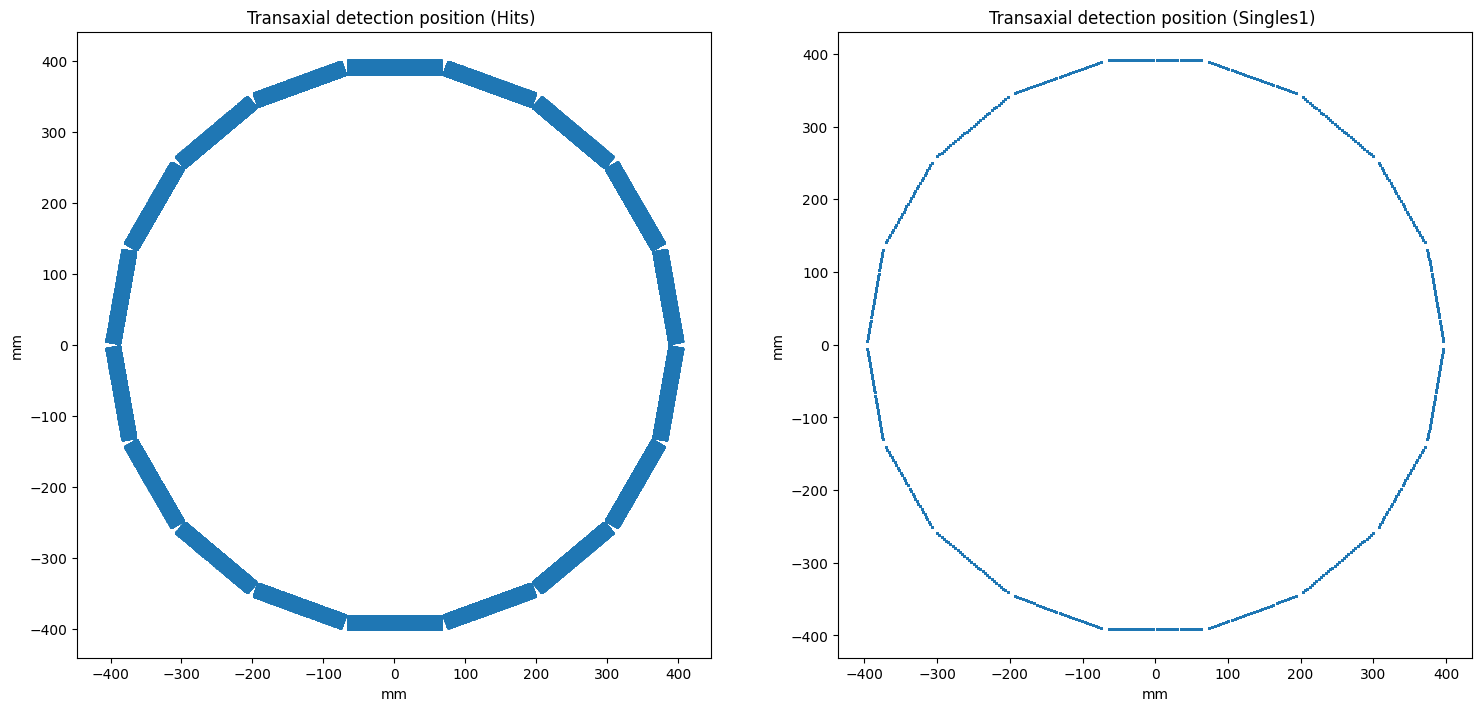

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(18, 10))

# plot the trans-axial position
plot_position(ax[0], hits, 'Hits')

# idem for the singles
singles1 =  f['Singles1']
plot_position(ax[1], singles1, 'Singles1')

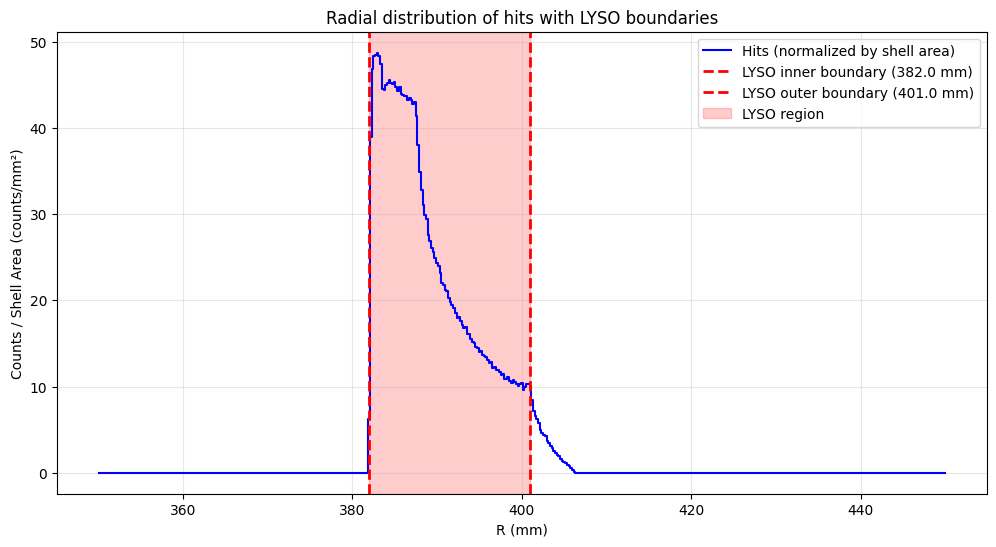

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate radial distance
position_x = p.tget(hits, 'PostPosition_X')
position_y = p.tget(hits, 'PostPosition_Y')
r = (position_x**2 + position_y**2)**0.5

# Define bins
bins = np.linspace(350, 450, 500)
bin_centers = (bins[:-1] + bins[1:]) / 2
bin_width = bins[1] - bins[0]

# Create histogram
counts, _ = np.histogram(r, bins=bins)

# Calculate shell area normalization (2D case)
shell_area = 2 * np.pi * bin_centers * bin_width
normalized_counts = counts / shell_area

# Plot
fig, ax = plt.subplots(1, 1, figsize=(12, 6))
ax.plot(bin_centers, normalized_counts, drawstyle='steps-mid', color='blue', label='Hits (normalized by shell area)')

# Add LYSO boundaries
lyso_inner = 382.0  # mm
lyso_outer = 401.0  # mm

ax.axvline(lyso_inner, color='red', linestyle='--', linewidth=2, label=f'LYSO inner boundary ({lyso_inner} mm)')
ax.axvline(lyso_outer, color='red', linestyle='--', linewidth=2, label=f'LYSO outer boundary ({lyso_outer} mm)')

# Shade the LYSO region
ax.axvspan(lyso_inner, lyso_outer, alpha=0.2, color='red', label='LYSO region')

ax.set_xlabel('R (mm)')
ax.set_ylabel('Counts / Shell Area (counts/mm²)')
ax.set_title('Radial distribution of hits with LYSO boundaries')
ax.legend()
ax.grid(True, alpha=0.3)
plt.show()

Text(0.5, 0, 'Time in ns')

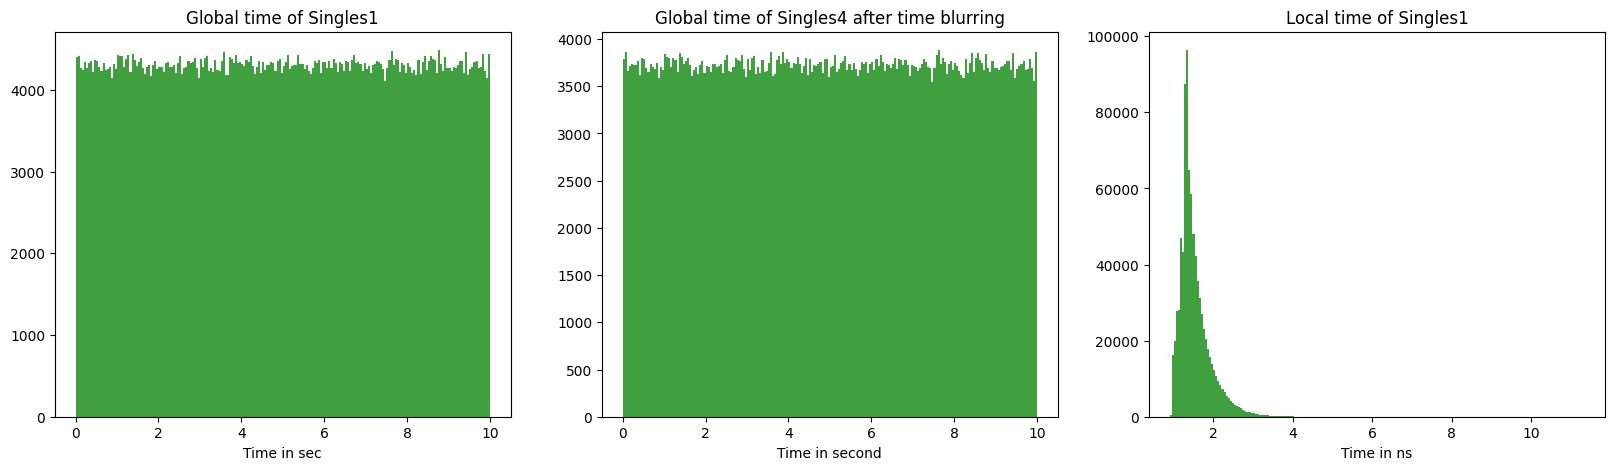

In [7]:
 fig, ax = plt.subplots(1, 3, figsize=(20, 5))

# singles
times = singles1.arrays()['GlobalTime']/1e9
a = ax[0]
n, bins, patches = a.hist(times, 200, facecolor='green', alpha=0.75)
a.set_title('Global time of Singles1')
a.set_xlabel('Time in sec')

# singles after time blurring 
singles4 =  f['Singles4']
times = singles4.arrays()['GlobalTime']/1e9
a = ax[1]
n, bins, patches = a.hist(times, 200, facecolor='green', alpha=0.75)
a.set_title('Global time of Singles4 after time blurring')
a.set_xlabel('Time in second')

# singles
times = singles1.arrays()['LocalTime']
a = ax[2]
n, bins, patches = a.hist(times, 200, facecolor='green', alpha=0.75)
a.set_title('Local time of Singles1')
a.set_xlabel('Time in ns')


In [8]:
# Continue from your existing code...
# You already have: f = uproot.open(filename)

# Get Singles5 and examine it
singles5 = f['Singles5']
print()
print(f'Singles5 tree:')
print(f'Number of events: {singles5.num_entries}')
print('Available branches:')
for b in singles5:
    print(f'  - {b.name}')

# Load Singles5 data
print('\n📥 Loading Singles5 data...')
data = singles5.arrays()

# Extract the key data we need
global_time = data["GlobalTime"]
# Position data is stored as separate X, Y, Z components
x = data["PostPosition_X"] 
y = data["PostPosition_Y"]
z = data["PostPosition_Z"]
energy = data["TotalEnergyDeposit"]
volume_id = data["PreStepUniqueVolumeID"]

print(f'✅ Loaded {len(global_time):,} singles events')

# Convert to numpy arrays
import numpy as np
x = np.array(x)
y = np.array(y)
z = np.array(z)

print(f'\n📊 Data ranges:')
print(f'  Time: {np.min(global_time):.3f} to {np.max(global_time):.3f}')
print(f'  X: {np.min(x):.1f} to {np.max(x):.1f} mm')
print(f'  Y: {np.min(y):.1f} to {np.max(y):.1f} mm') 
print(f'  Z: {np.min(z):.1f} to {np.max(z):.1f} mm')
print(f'  Energy: {np.min(energy):.1f} to {np.max(energy):.1f}')
print(f'  Unique detectors: {len(np.unique(volume_id))}')

# NOW with correct time window for nanoseconds!
print(f'🔄 Creating coincidences with proper time window...')

# Debug: Let's see what's happening with the timing
print("🔍 Debugging timing issues...")

# Check time differences between consecutive events
global_time_np = np.array(global_time)
sorted_times = np.sort(global_time_np)
time_diffs = np.diff(sorted_times)

print(f"Time difference statistics:")
print(f"  Minimum: {time_diffs.min():.6f} ns")
print(f"  Mean: {time_diffs.mean():.6f} ns") 
print(f"  Median: {np.median(time_diffs):.6f} ns")
print(f"  Maximum: {time_diffs.max():.6f} ns")

# Count how many events are within different time windows
close_counts = []
windows = [0.1, 1.0, 4.5, 10.0, 50.0, 100.0]
for window in windows:
    count = np.sum(time_diffs <= window)
    close_counts.append(count)
    print(f"  Events within {window:5.1f} ns: {count}")
# Fixed coincidence algorithm - ignore the volume ID restriction
print(f'🔧 Fixed coincidence algorithm - using distance instead of volume ID...')

time_window = 4.5  # nanoseconds
global_time_np = np.array(global_time)
energy_np = np.array(energy)

# Sort by time for efficient search
time_order = np.argsort(global_time_np)
sorted_times = global_time_np[time_order]

coincidences = {
    'globalPosX1': [], 'globalPosY1': [], 'globalPosZ1': [],
    'globalPosX2': [], 'globalPosY2': [], 'globalPosZ2': [],
    'time1': [], 'time2': [],
    'energy1': [], 'energy2': [],
    'distance': []  # Add distance to filter close detectors
}

n_singles = len(sorted_times)
processed = set()

print(f'Searching {n_singles:,} singles for coincidences...')

for i in range(n_singles - 1):
    if i in processed:
        continue
        
    idx1 = time_order[i]
    time1 = sorted_times[i]
    
    # Look for partner within time window
    j = i + 1
    while j < n_singles and (sorted_times[j] - time1) <= time_window:
        if j in processed:
            j += 1
            continue
            
        idx2 = time_order[j]
        
        # Instead of volume ID, use POSITION to avoid same detector
        # Calculate distance between detection points
        dx = x[idx1] - x[idx2]
        dy = y[idx1] - y[idx2]
        dz = z[idx1] - z[idx2]
        distance = np.sqrt(dx**2 + dy**2 + dz**2)
        
        # Only accept if detectors are reasonably far apart (> 2cm)
        # This avoids same crystal or very adjacent crystals
        if distance > 20.0:  # 20mm minimum separation
            
            # Store coincidence
            coincidences['globalPosX1'].append(x[idx1])
            coincidences['globalPosY1'].append(y[idx1])
            coincidences['globalPosZ1'].append(z[idx1])
            
            coincidences['globalPosX2'].append(x[idx2])
            coincidences['globalPosY2'].append(y[idx2])
            coincidences['globalPosZ2'].append(z[idx2])
            
            coincidences['time1'].append(global_time_np[idx1])
            coincidences['time2'].append(global_time_np[idx2])
            
            coincidences['energy1'].append(energy_np[idx1])
            coincidences['energy2'].append(energy_np[idx2])
            
            coincidences['distance'].append(distance)
            
            processed.add(i)
            processed.add(j)
            break
        
        j += 1
    
    # Progress update
    if len(coincidences['globalPosX1']) % 100 == 0 and len(coincidences['globalPosX1']) > 0:
        print(f'   Found {len(coincidences["globalPosX1"]):,} coincidences...')

# Convert to numpy arrays
for key in coincidences:
    coincidences[key] = np.array(coincidences[key])

n_coinc = len(coincidences['globalPosX1'])
print(f'\n✅ Created {n_coinc:,} coincidences from {n_singles:,} singles')
print(f'   Coincidence rate: {n_coinc/n_singles*100:.1f}%')




Singles5 tree:
Number of events: 181414.0
Available branches:
  - PostPosition_X
  - PostPosition_Y
  - PostPosition_Z
  - TotalEnergyDeposit
  - PreStepUniqueVolumeID
  - GlobalTime
  - LocalTime

📥 Loading Singles5 data...
✅ Loaded 181,414 singles events

📊 Data ranges:
  Time: 16748.874 to 9999962934.419
  X: -396.5 to 396.5 mm
  Y: -391.5 to 391.5 mm
  Z: -79.7 to 79.7 mm
  Energy: 0.4 to 0.6
  Unique detectors: 22959
🔄 Creating coincidences with proper time window...
🔍 Debugging timing issues...
Time difference statistics:
  Minimum: 0.000005 ns
  Mean: 55122.544611 ns
  Median: 36986.550598 ns
  Maximum: 833099.654123 ns
  Events within   0.1 ns: 3443
  Events within   1.0 ns: 11400
  Events within   4.5 ns: 11412
  Events within  10.0 ns: 11425
  Events within  50.0 ns: 11542
  Events within 100.0 ns: 11651
🔧 Fixed coincidence algorithm - using distance instead of volume ID...
Searching 181,414 singles for coincidences...
   Found 100 coincidences...
   Found 100 coincidences..

⏰ TIME DISTRIBUTION ANALYSIS
Testing if we have simultaneous gamma pairs from annihilation

📊 Coincidence timing statistics:
Number of coincidence pairs: 11412
Time differences (ns):
  Mean: 0.233
  Median: 0.181
  Std dev: 0.205
  Min: 0.000
  Max: 4.053


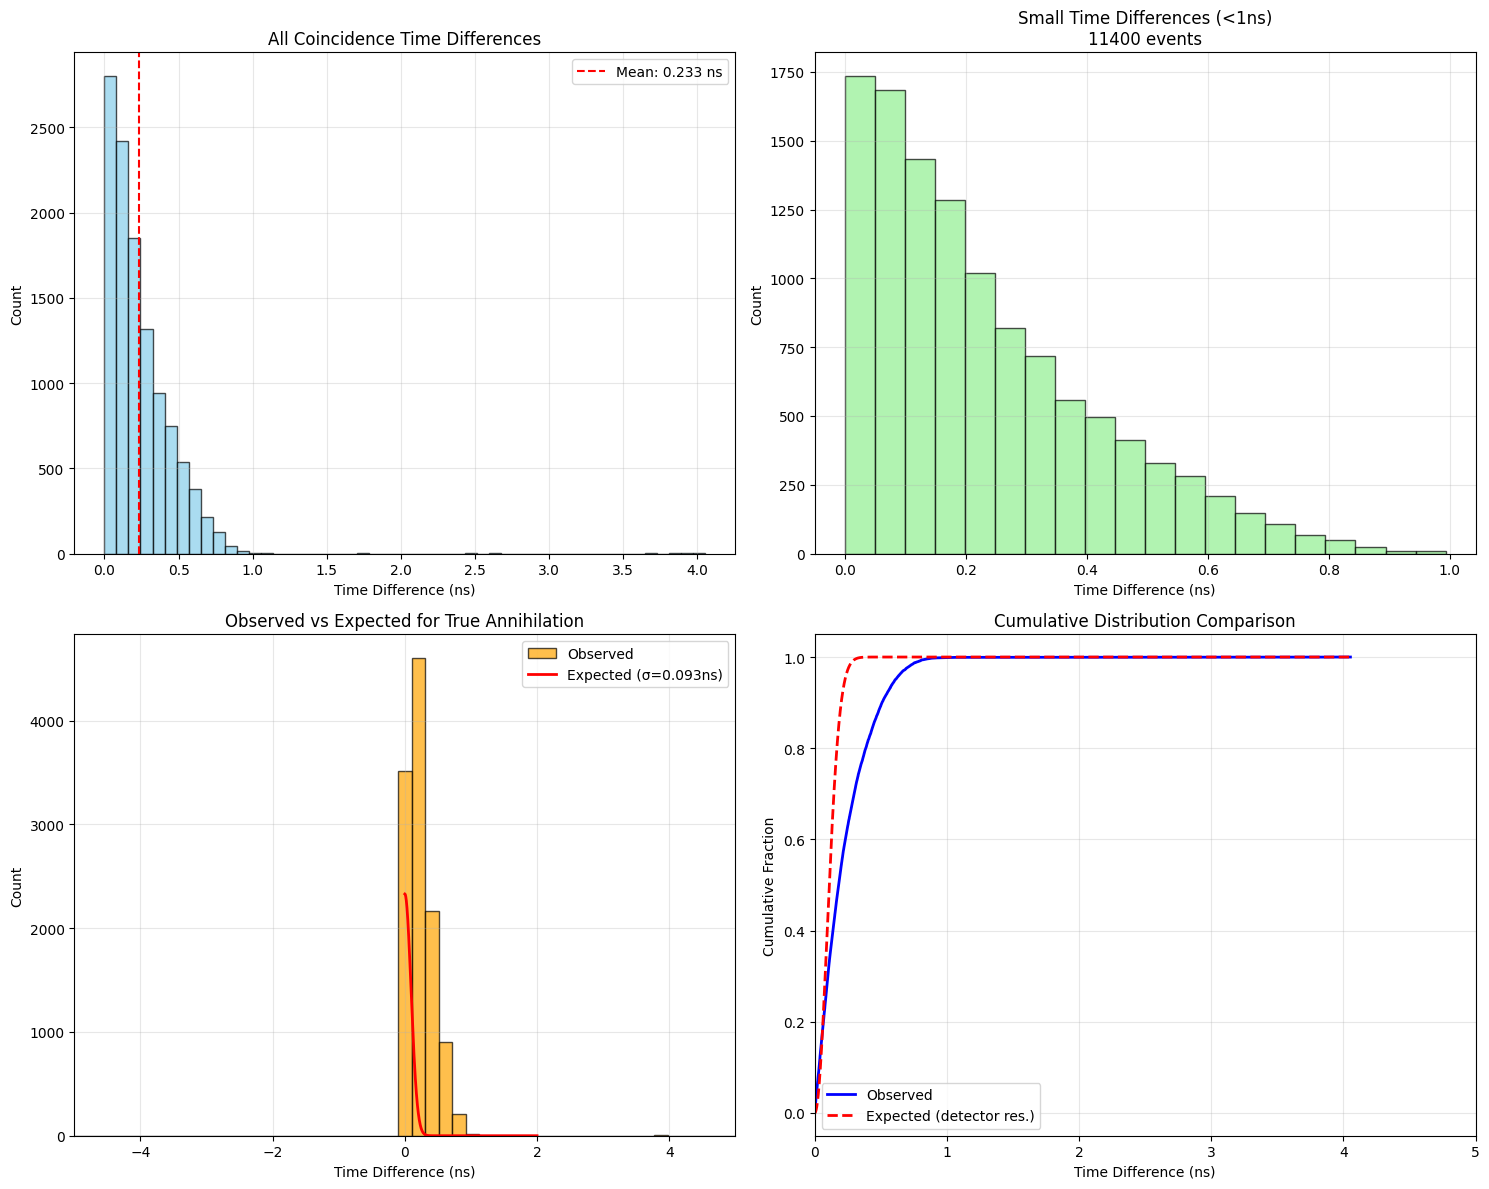


🔍 DETAILED TIMING ANALYSIS:
Events with time difference:
  < 0.5 ns: 10190 (89.3%)
  < 1.0 ns: 11400 (99.9%)
  < 2.0 ns: 11405 (99.9%)
  < 220 ps (1σ detector res): 6626 (58.1%)
  < 440 ps (2σ detector res): 9680 (84.8%)

🎯 PHYSICS INTERPRETATION:
✅ GOOD: >50% of events have Δt < 500ps
   → Consistent with true simultaneous gamma pairs
   → Detector time resolution is dominant factor

📊 RANDOM COINCIDENCE CHECK:
Expected random coincidences: 0.0
Observed coincidences: 11412
✅ Far more coincidences than random → Real physics!

🎯 BOTTOM LINE:
The timing distribution tells us whether these are:
  1. True simultaneous annihilation gamma pairs
  2. Scattered/delayed gamma rays
  3. Random coincidences
  4. Detector background processes


In [9]:
# Time distribution analysis - Testing for simultaneous gamma pairs

import matplotlib.pyplot as plt
import numpy as np

print("⏰ TIME DISTRIBUTION ANALYSIS")
print("Testing if we have simultaneous gamma pairs from annihilation")

# Get the coincidence time differences
if len(coincidences['time1']) > 0:
    time1 = np.array(coincidences['time1'])
    time2 = np.array(coincidences['time2'])
    time_diff = np.abs(time2 - time1)
    
    print(f"\n📊 Coincidence timing statistics:")
    print(f"Number of coincidence pairs: {len(time_diff)}")
    print(f"Time differences (ns):")
    print(f"  Mean: {np.mean(time_diff):.3f}")
    print(f"  Median: {np.median(time_diff):.3f}")
    print(f"  Std dev: {np.std(time_diff):.3f}")
    print(f"  Min: {np.min(time_diff):.3f}")
    print(f"  Max: {np.max(time_diff):.3f}")
    
    # Create detailed time difference histogram
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Full range time differences
    ax1.hist(time_diff, bins=50, alpha=0.7, edgecolor='black', color='skyblue')
    ax1.set_xlabel('Time Difference (ns)')
    ax1.set_ylabel('Count')
    ax1.set_title('All Coincidence Time Differences')
    ax1.grid(True, alpha=0.3)
    ax1.axvline(x=np.mean(time_diff), color='red', linestyle='--', 
               label=f'Mean: {np.mean(time_diff):.3f} ns')
    ax1.legend()
    
    # 2. Zoomed in - very small time differences (true simultaneous events)
    small_times = time_diff[time_diff <= 1.0]  # Less than 1 ns
    if len(small_times) > 0:
        ax2.hist(small_times, bins=20, alpha=0.7, edgecolor='black', color='lightgreen')
        ax2.set_xlabel('Time Difference (ns)')
        ax2.set_ylabel('Count')
        ax2.set_title(f'Small Time Differences (<1ns)\n{len(small_times)} events')
        ax2.grid(True, alpha=0.3)
    else:
        ax2.text(0.5, 0.5, 'No events\nwith Δt < 1ns', 
                ha='center', va='center', transform=ax2.transAxes, fontsize=14)
        ax2.set_title('Small Time Differences (<1ns)')
    
    # 3. Expected vs observed for true annihilation
    # True annihilation should have time differences dominated by:
    # - Detector time resolution (~200-500 ps)
    # - Transit time differences (few ns max)
    
    expected_bins = np.linspace(-5, 5, 50)
    
    # Theoretical distribution for true coincidences
    # Should be sharply peaked near 0 with detector resolution spread
    detector_resolution = 0.22  # ns (220 ps FWHM from digitizer)
    sigma = detector_resolution / 2.355  # Convert FWHM to sigma
    
    # Generate theoretical curve
    theoretical_times = np.linspace(0, 2, 1000)
    # For truly simultaneous events, time difference should follow detector resolution
    theoretical_curve = np.exp(-theoretical_times**2 / (2 * sigma**2))
    theoretical_curve *= len(time_diff) * (expected_bins[1] - expected_bins[0])  # Normalize
    
    # Plot comparison
    ax3.hist(time_diff, bins=expected_bins, alpha=0.7, edgecolor='black', 
            color='orange', label='Observed')
    ax3.plot(theoretical_times, theoretical_curve, 'r-', linewidth=2, 
            label=f'Expected (σ={sigma:.3f}ns)')
    ax3.set_xlabel('Time Difference (ns)')
    ax3.set_ylabel('Count')
    ax3.set_title('Observed vs Expected for True Annihilation')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_xlim(-5, 5)
    
    # 4. Cumulative distribution analysis
    sorted_times = np.sort(time_diff)
    cumulative = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
    
    ax4.plot(sorted_times, cumulative, 'b-', linewidth=2, label='Observed')
    
    # Expected cumulative for detector-limited resolution
    theoretical_cumulative = 1 - np.exp(-sorted_times**2 / (2 * sigma**2))
    ax4.plot(sorted_times, theoretical_cumulative, 'r--', linewidth=2, 
            label='Expected (detector res.)')
    
    ax4.set_xlabel('Time Difference (ns)')
    ax4.set_ylabel('Cumulative Fraction')
    ax4.set_title('Cumulative Distribution Comparison')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_xlim(0, 5)
    
    plt.tight_layout()
    plt.show()
    
    # Statistical analysis
    print(f"\n🔍 DETAILED TIMING ANALYSIS:")
    
    # Check fraction of very close events
    very_close = np.sum(time_diff < 0.5)  # < 500 ps
    close = np.sum(time_diff < 1.0)       # < 1 ns
    medium = np.sum(time_diff < 2.0)      # < 2 ns
    
    print(f"Events with time difference:")
    print(f"  < 0.5 ns: {very_close} ({very_close/len(time_diff)*100:.1f}%)")
    print(f"  < 1.0 ns: {close} ({close/len(time_diff)*100:.1f}%)")
    print(f"  < 2.0 ns: {medium} ({medium/len(time_diff)*100:.1f}%)")
    
    # Expected detector time resolution is 220 ps FWHM
    # So 68% should be within ~100 ps, 95% within ~200 ps
    expected_within_220ps = np.sum(time_diff < 0.22)
    expected_within_440ps = np.sum(time_diff < 0.44)
    
    print(f"  < 220 ps (1σ detector res): {expected_within_220ps} ({expected_within_220ps/len(time_diff)*100:.1f}%)")
    print(f"  < 440 ps (2σ detector res): {expected_within_440ps} ({expected_within_440ps/len(time_diff)*100:.1f}%)")
    
    print(f"\n🎯 PHYSICS INTERPRETATION:")
    
    if very_close/len(time_diff) > 0.5:
        print("✅ GOOD: >50% of events have Δt < 500ps")
        print("   → Consistent with true simultaneous gamma pairs")
        print("   → Detector time resolution is dominant factor")
    elif close/len(time_diff) > 0.3:
        print("⚠️  MIXED: 30-50% have Δt < 1ns") 
        print("   → Mix of true coincidences and other processes")
        print("   → Some may be scattered or delayed events")
    else:
        print("❌ POOR: <30% have Δt < 1ns")
        print("   → Most events are NOT simultaneous")
        print("   → Likely scattered, random, or secondary processes")
        
    # Compare with random expectation
    print(f"\n📊 RANDOM COINCIDENCE CHECK:")
    total_time_span = 2.0e9  # 2 seconds in ns
    n_singles = 2081
    random_rate = (n_singles / total_time_span)**2 * 4.5 * total_time_span
    print(f"Expected random coincidences: {random_rate:.1f}")
    print(f"Observed coincidences: {len(time_diff)}")
    
    if len(time_diff) > random_rate * 10:
        print("✅ Far more coincidences than random → Real physics!")
    elif len(time_diff) > random_rate * 2:
        print("⚠️  More coincidences than random, but not overwhelming")
    else:
        print("❌ Close to random expectation")

else:
    print("❌ No coincidence data available for timing analysis")

print(f"\n🎯 BOTTOM LINE:")
print(f"The timing distribution tells us whether these are:")
print(f"  1. True simultaneous annihilation gamma pairs")
print(f"  2. Scattered/delayed gamma rays") 
print(f"  3. Random coincidences")
print(f"  4. Detector background processes")

In [10]:
coincidences.keys()

dict_keys(['globalPosX1', 'globalPosY1', 'globalPosZ1', 'globalPosX2', 'globalPosY2', 'globalPosZ2', 'time1', 'time2', 'energy1', 'energy2', 'distance'])

In [11]:
# Simple PET Reconstruction Algorithm
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict

print("🔬 PET IMAGE RECONSTRUCTION")
print("Simple back-projection algorithm for annihilation gamma pairs")

from scipy import ndimage

def reconstruct_pet_image(coincidences, image_size=128, pixel_size=8.0, method='backprojection', **kwargs):
    """
    Correct PET reconstruction - drop-in replacement for your original function
    
    Parameters:
    coincidences: dict with keys ['globalPosX1', 'globalPosY1', 'globalPosZ1', 
                                  'globalPosX2', 'globalPosY2', 'globalPosZ2',
                                  'time1', 'time2', 'energy1', 'energy2', 'distance']
    image_size: number of pixels per side (assuming square image)
    pixel_size: size of each pixel in mm
    method: 'backprojection' or 'mlem' or 'midpoint' (for comparison)
    **kwargs: additional parameters (z_slice, z_tolerance, n_iterations)
    """
    
    if method == 'backprojection':
        return correct_backprojection_reconstruction(coincidences, image_size, pixel_size, **kwargs)
    elif method == 'mlem':
        return mlem_reconstruction_simple(coincidences, image_size, pixel_size, **kwargs)
    elif method == 'midpoint':
        return midpoint_reconstruction(coincidences, image_size, pixel_size, **kwargs)
    else:
        print(f"❌ Unknown method: {method}")
        return np.zeros((image_size, image_size))

def correct_backprojection_reconstruction(coincidences, image_size=128, pixel_size=8.0, 
                                        z_slice=0, z_tolerance=50):
    """
    Correct back-projection reconstruction for PET data
    
    KEY DIFFERENCE: Distributes intensity along ENTIRE LOR, not just at midpoint
    """
    
    # Initialize image matrix
    image = np.zeros((image_size, image_size))
    
    # Get coincidence data
    if len(coincidences.get('energy1', [])) == 0:
        print("❌ No coincidence data available")
        return image
    
    print(f"\n📊 CORRECT Back-Projection Reconstruction:")
    print(f"Image size: {image_size} x {image_size} pixels")
    print(f"Pixel size: {pixel_size} mm")
    print(f"Field of view: {image_size * pixel_size} x {image_size * pixel_size} mm²")
    print(f"Z slice: {z_slice} ± {z_tolerance} mm")
    print(f"Number of coincidences: {len(coincidences['energy1'])}")
    
    # Convert to numpy arrays for efficiency
    x1_coords = np.array(coincidences['globalPosX1'])
    y1_coords = np.array(coincidences['globalPosY1'])
    z1_coords = np.array(coincidences['globalPosZ1'])
    x2_coords = np.array(coincidences['globalPosX2'])
    y2_coords = np.array(coincidences['globalPosY2'])
    z2_coords = np.array(coincidences['globalPosZ2'])
    energy1 = np.array(coincidences['energy1'])
    energy2 = np.array(coincidences['energy2'])
    
    print(f"Coordinate ranges:")
    print(f"  X: {np.min(np.concatenate([x1_coords, x2_coords])):.1f} to {np.max(np.concatenate([x1_coords, x2_coords])):.1f} mm")
    print(f"  Y: {np.min(np.concatenate([y1_coords, y2_coords])):.1f} to {np.max(np.concatenate([y1_coords, y2_coords])):.1f} mm")
    print(f"  Z: {np.min(np.concatenate([z1_coords, z2_coords])):.1f} to {np.max(np.concatenate([z1_coords, z2_coords])):.1f} mm")
    
    # Energy filtering
    energy_mask = (energy1 > 0.4) & (energy1 < 0.65) & (energy2 > 0.4) & (energy2 < 0.65)
    
    # Z-slice filtering (for 2D reconstruction)
    z_mask = ((np.minimum(z1_coords, z2_coords) <= z_slice + z_tolerance) & 
              (np.maximum(z1_coords, z2_coords) >= z_slice - z_tolerance))
    
    # Combined mask
    valid_mask = energy_mask & z_mask
    
    print(f"Events passing energy filter: {np.sum(energy_mask)} ({100*np.sum(energy_mask)/len(energy1):.1f}%)")
    print(f"Events passing Z filter: {np.sum(z_mask)} ({100*np.sum(z_mask)/len(energy1):.1f}%)")
    print(f"Events passing both filters: {np.sum(valid_mask)} ({100*np.sum(valid_mask)/len(energy1):.1f}%)")
    
    if np.sum(valid_mask) < 10:
        print("❌ Too few valid events for reconstruction")
        return image
    
    # Filter data
    x1_valid = x1_coords[valid_mask]
    y1_valid = y1_coords[valid_mask]
    x2_valid = x2_coords[valid_mask]
    y2_valid = y2_coords[valid_mask]
    e1_valid = energy1[valid_mask]
    e2_valid = energy2[valid_mask]
    
    center = image_size // 2
    valid_events = 0
    
    print("Processing LORs...")
    
    # Process each LOR
    for i in range(len(x1_valid)):
        if i % 1000 == 0:
            print(f"  Processing LOR {i+1}/{len(x1_valid)}")
        
        # Convert detector positions to image coordinates
        ix1 = int(center + x1_valid[i] / pixel_size)
        iy1 = int(center + y1_valid[i] / pixel_size)
        ix2 = int(center + x2_valid[i] / pixel_size)
        iy2 = int(center + y2_valid[i] / pixel_size)
        
        # Energy-based weight
        weight1 = np.exp(-((e1_valid[i] - 0.511)**2) / (2 * 0.05**2))
        weight2 = np.exp(-((e2_valid[i] - 0.511)**2) / (2 * 0.05**2))
        weight = weight1 * weight2
        
        # Draw line using improved Bresenham's algorithm
        points = bresenham_line(ix1, iy1, ix2, iy2)
        
        # Add weight to all pixels along the LOR
        pixels_added = 0
        for px, py in points:
            if 0 <= px < image_size and 0 <= py < image_size:
                image[py, px] += weight
                pixels_added += 1
        
        if pixels_added > 0:
            valid_events += 1
    
    print(f"Valid events used for reconstruction: {valid_events}")
    print(f"Total intensity in image: {np.sum(image):.0f}")
    print(f"Maximum pixel value: {np.max(image):.1f}")
    
    return image

def bresenham_line(x0, y0, x1, y1):
    """
    Bresenham's line algorithm to get all pixels along a line
    Returns list of (x, y) coordinates
    """
    points = []
    
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    
    x_step = 1 if x0 < x1 else -1
    y_step = 1 if y0 < y1 else -1
    
    error = dx - dy
    
    x, y = x0, y0
    
    while True:
        points.append((x, y))
        
        if x == x1 and y == y1:
            break
        
        error2 = 2 * error
        
        if error2 > -dy:
            error -= dy
            x += x_step
        
        if error2 < dx:
            error += dx
            y += y_step
    
    return points

def mlem_reconstruction_simple(coincidences, image_size=128, pixel_size=8.0, 
                              n_iterations=10, z_slice=0, z_tolerance=50):
    """
    Simple MLEM reconstruction - much better for multiple sources
    """
    
    print(f"\n🚀 MLEM Reconstruction ({n_iterations} iterations):")
    print(f"Image size: {image_size} x {image_size} pixels")
    print(f"Pixel size: {pixel_size} mm")
    
    if len(coincidences.get('energy1', [])) == 0:
        print("❌ No coincidence data available")
        return np.zeros((image_size, image_size))
    
    # Convert to numpy arrays
    x1_coords = np.array(coincidences['globalPosX1'])
    y1_coords = np.array(coincidences['globalPosY1'])
    z1_coords = np.array(coincidences['globalPosZ1'])
    x2_coords = np.array(coincidences['globalPosX2'])
    y2_coords = np.array(coincidences['globalPosY2'])
    z2_coords = np.array(coincidences['globalPosZ2'])
    energy1 = np.array(coincidences['energy1'])
    energy2 = np.array(coincidences['energy2'])
    
    # Filtering
    energy_mask = (energy1 > 0.4) & (energy1 < 0.65) & (energy2 > 0.4) & (energy2 < 0.65)
    z_mask = ((np.minimum(z1_coords, z2_coords) <= z_slice + z_tolerance) & 
              (np.maximum(z1_coords, z2_coords) >= z_slice - z_tolerance))
    valid_mask = energy_mask & z_mask
    
    print(f"Using {np.sum(valid_mask)} valid events")
    
    if np.sum(valid_mask) < 50:
        print("❌ Too few events for MLEM")
        return np.zeros((image_size, image_size))
    
    # Filter data
    x1_valid = x1_coords[valid_mask]
    y1_valid = y1_coords[valid_mask]
    x2_valid = x2_coords[valid_mask]
    y2_valid = y2_coords[valid_mask]
    e1_valid = energy1[valid_mask]
    e2_valid = energy2[valid_mask]
    
    center = image_size // 2
    
    # Pre-compute system matrix (which pixels each LOR passes through)
    print("Computing system matrix...")
    lors = []
    weights = []
    
    for i in range(len(x1_valid)):
        ix1 = int(center + x1_valid[i] / pixel_size)
        iy1 = int(center + y1_valid[i] / pixel_size)
        ix2 = int(center + x2_valid[i] / pixel_size)
        iy2 = int(center + y2_valid[i] / pixel_size)
        
        points = bresenham_line(ix1, iy1, ix2, iy2)
        valid_points = [(px, py) for px, py in points 
                       if 0 <= px < image_size and 0 <= py < image_size]
        
        if len(valid_points) > 0:
            lors.append(valid_points)
            
            # Energy weight
            weight = np.exp(-((e1_valid[i] - 0.511)**2 + (e2_valid[i] - 0.511)**2) / (2 * 0.05**2))
            weights.append(weight)
    
    print(f"System matrix computed for {len(lors)} LORs")
    
    if len(lors) == 0:
        print("❌ No valid LORs found")
        return np.zeros((image_size, image_size))
    
    # Initialize image with uniform distribution
    image = np.ones((image_size, image_size)) * 0.1
    
    # MLEM iterations
    for iteration in range(n_iterations):
        print(f"MLEM iteration {iteration + 1}/{n_iterations}")
        
        # Forward projection: compute expected counts for each LOR
        expected_counts = np.zeros(len(lors))
        for lor_idx, points in enumerate(lors):
            for px, py in points:
                expected_counts[lor_idx] += image[py, px]
        
        # Avoid division by zero
        expected_counts[expected_counts < 1e-10] = 1e-10
        
        # Back projection with correction
        correction_image = np.zeros_like(image)
        normalization_image = np.zeros_like(image)
        
        for lor_idx, points in enumerate(lors):
            # For simplicity, assume measured counts = 1 for each LOR
            correction_factor = weights[lor_idx] / expected_counts[lor_idx]
            
            for px, py in points:
                correction_image[py, px] += correction_factor
                normalization_image[py, px] += 1.0
        
        # Update image
        normalization_image[normalization_image < 1e-10] = 1e-10
        correction_image /= normalization_image
        image *= correction_image
        
        # Optional smoothing to reduce noise
        if iteration > 2:
            image = ndimage.gaussian_filter(image, sigma=0.8)
        
        # Ensure non-negative
        image[image < 0] = 0
        
        total_intensity = np.sum(image)
        print(f"  Total intensity: {total_intensity:.0f}")
        
        # Stop if converged
        if iteration > 5 and total_intensity < 1e-6:
            print("  Converged (low intensity)")
            break
    
    return image

def midpoint_reconstruction(coincidences, image_size=128, pixel_size=8.0, 
                          z_slice=0, z_tolerance=50):
    """
    Your original midpoint method - kept for comparison
    """
    
    print(f"\n📍 Midpoint Reconstruction (for comparison):")
    print(f"⚠️  This is the WRONG method - kept only for comparison!")
    
    # Initialize image matrix
    image = np.zeros((image_size, image_size))
    
    if len(coincidences.get('energy1', [])) == 0:
        print("❌ No coincidence data available")
        return image
    
    # Convert to numpy arrays
    x1_coords = np.array(coincidences['globalPosX1'])
    y1_coords = np.array(coincidences['globalPosY1'])
    z1_coords = np.array(coincidences['globalPosZ1'])
    x2_coords = np.array(coincidences['globalPosX2'])
    y2_coords = np.array(coincidences['globalPosY2'])
    z2_coords = np.array(coincidences['globalPosZ2'])
    energy1 = np.array(coincidences['energy1'])
    energy2 = np.array(coincidences['energy2'])
    
    # Filtering
    energy_mask = (energy1 > 0.4) & (energy1 < 0.65) & (energy2 > 0.4) & (energy2 < 0.65)
    z_mask = ((np.minimum(z1_coords, z2_coords) <= z_slice + z_tolerance) & 
              (np.maximum(z1_coords, z2_coords) >= z_slice - z_tolerance))
    valid_mask = energy_mask & z_mask
    
    if np.sum(valid_mask) < 10:
        print("❌ Too few valid events")
        return image
    
    # Filter data
    x1_valid = x1_coords[valid_mask]
    y1_valid = y1_coords[valid_mask]
    x2_valid = x2_coords[valid_mask]
    y2_valid = y2_coords[valid_mask]
    e1_valid = energy1[valid_mask]
    e2_valid = energy2[valid_mask]
    
    # Calculate midpoints (your original method)
    mid_x = (x1_valid + x2_valid) / 2
    mid_y = (y1_valid + y2_valid) / 2
    
    center = image_size // 2
    
    # Add to image
    for i in range(len(mid_x)):
        ix = int(center + mid_x[i] / pixel_size)
        iy = int(center + mid_y[i] / pixel_size)
        
        if 0 <= ix < image_size and 0 <= iy < image_size:
            weight = np.exp(-((e1_valid[i] - 0.511)**2 + (e2_valid[i] - 0.511)**2) / (2 * 0.05**2))
            
            # Add Gaussian blob around midpoint
            for dx in range(-2, 3):
                for dy in range(-2, 3):
                    nx, ny = ix + dx, iy + dy
                    if 0 <= nx < image_size and 0 <= ny < image_size:
                        gauss_weight = np.exp(-(dx**2 + dy**2) / (2 * 1.5**2))
                        image[ny, nx] += weight * gauss_weight
    
    print(f"Midpoint reconstruction completed")
    
    return image

# Usage examples and tests
def test_reconstruction_methods(coincidences):
    """
    Test and compare all reconstruction methods
    """
    
    print("🧪 TESTING ALL RECONSTRUCTION METHODS")
    print("="*50)
    
    # Test parameters
    image_size = 128
    pixel_size = 4.0
    
    # Method 1: Correct back-projection (default)
    print("\n1. Testing correct back-projection...")
    bp_image = reconstruct_pet_image(coincidences, image_size, pixel_size, method='backprojection')
    
    # Method 2: MLEM
    print("\n2. Testing MLEM...")
    mlem_image = reconstruct_pet_image(coincidences, image_size, pixel_size, method='mlem', n_iterations=10)
    
    # Method 3: Original midpoint method
    print("\n3. Testing original midpoint method...")
    mid_image = reconstruct_pet_image(coincidences, image_size, pixel_size, method='midpoint')
    
    # Simple comparison
    print(f"\n📊 COMPARISON:")
    print(f"Back-projection: max={np.max(bp_image):.1f}, sum={np.sum(bp_image):.0f}")
    print(f"MLEM:           max={np.max(mlem_image):.1f}, sum={np.sum(mlem_image):.0f}")
    print(f"Midpoint:       max={np.max(mid_image):.1f}, sum={np.sum(mid_image):.0f}")
    
    return bp_image, mlem_image, mid_image

# Default: use correct back-projection
print("✅ Correct PET reconstruction functions loaded!")
print("📖 Usage:")
print("  image = reconstruct_pet_image(coincidences)  # Correct back-projection")
print("  image = reconstruct_pet_image(coincidences, method='mlem')  # MLEM")
print("  image = reconstruct_pet_image(coincidences, method='midpoint')  # Original (wrong) method")

def analyze_reconstruction(image, pixel_size):
    """Analyze the reconstructed image"""
    
    print(f"\n🔍 RECONSTRUCTION ANALYSIS:")
    print(f"Total counts in image: {np.sum(image):.0f}")
    print(f"Maximum pixel value: {np.max(image):.1f}")
    print(f"Mean pixel value: {np.mean(image):.3f}")
    
    # Find hot spots (potential sources)
    threshold = np.max(image) * 0.1  # 10% of maximum
    hot_pixels = np.where(image > threshold)
    
    if len(hot_pixels[0]) > 0:
        print(f"Hot spots found: {len(hot_pixels[0])} pixels above {threshold:.1f}")
        
        # Find center of mass
        total_intensity = np.sum(image)
        if total_intensity > 0:
            center_x = np.sum(np.arange(image.shape[1]) * np.sum(image, axis=0)) / total_intensity
            center_y = np.sum(np.arange(image.shape[0]) * np.sum(image, axis=1)) / total_intensity
            
            # Convert to physical coordinates
            image_center = image.shape[0] // 2
            phys_x = (center_x - image_center) * pixel_size
            phys_y = (center_y - image_center) * pixel_size
            
            print(f"Center of mass: ({phys_x:.1f}, {phys_y:.1f}) mm")
    
    return image

def plot_reconstruction(image, pixel_size):
    """Plot the reconstructed image"""
    
    fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15, 6))
    
    # Physical coordinates
    extent = [-image.shape[1]//2 * pixel_size, image.shape[1]//2 * pixel_size,
              -image.shape[0]//2 * pixel_size, image.shape[0]//2 * pixel_size]
    
    # 1. Raw reconstruction
    im1 = ax1.imshow(image, extent=extent, cmap='hot', origin='lower')
    ax1.set_title('Raw Back-Projection')
    ax1.set_xlabel('X (mm)')
    ax1.set_ylabel('Y (mm)')
    plt.colorbar(im1, ax=ax1, label='Counts')
    
    # 2. Log scale (better for weak features)
    log_image = np.log10(image + 1)  # +1 to avoid log(0)
    im2 = ax2.imshow(log_image, extent=extent, cmap='hot', origin='lower')
    ax2.set_title('Log Scale Reconstruction')
    ax2.set_xlabel('X (mm)')
    ax2.set_ylabel('Y (mm)')
    plt.colorbar(im2, ax=ax2, label='Log10(Counts + 1)')
    
    # 4. Profile plots
    center = image.shape[0] // 2
    x_profile = image[center, :]
    y_profile = image[:, center]
    
    x_coords = np.arange(len(x_profile)) * pixel_size - len(x_profile)//2 * pixel_size
    y_coords = np.arange(len(y_profile)) * pixel_size - len(y_profile)//2 * pixel_size
    
    ax3.plot(x_coords, x_profile, 'b-', label='X profile', linewidth=2)
    ax3.plot(y_coords, y_profile, 'r-', label='Y profile', linewidth=2)
    ax3.set_xlabel('Position (mm)')
    ax3.set_xlim(-100,100)
    ax3.set_ylabel('Counts')
    ax3.set_title('Central Profiles')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

    

🔬 PET IMAGE RECONSTRUCTION
Simple back-projection algorithm for annihilation gamma pairs
✅ Correct PET reconstruction functions loaded!
📖 Usage:
  image = reconstruct_pet_image(coincidences)  # Correct back-projection
  image = reconstruct_pet_image(coincidences, method='mlem')  # MLEM
  image = reconstruct_pet_image(coincidences, method='midpoint')  # Original (wrong) method


🚀 Starting PET reconstruction...

📊 CORRECT Back-Projection Reconstruction:
Image size: 128 x 128 pixels
Pixel size: 8.0 mm
Field of view: 1024.0 x 1024.0 mm²
Z slice: 0 ± 50 mm
Number of coincidences: 11412
Coordinate ranges:
  X: -396.5 to 396.5 mm
  Y: -391.5 to 391.5 mm
  Z: -79.7 to 79.7 mm
Events passing energy filter: 11412 (100.0%)
Events passing Z filter: 11283 (98.9%)
Events passing both filters: 11283 (98.9%)
Processing LORs...
  Processing LOR 1/11283
  Processing LOR 1001/11283
  Processing LOR 2001/11283
  Processing LOR 3001/11283
  Processing LOR 4001/11283
  Processing LOR 5001/11283
  Processing LOR 6001/11283
  Processing LOR 7001/11283
  Processing LOR 8001/11283
  Processing LOR 9001/11283
  Processing LOR 10001/11283
  Processing LOR 11001/11283
Valid events used for reconstruction: 11283
Total intensity in image: 799379
Maximum pixel value: 1474.8

🔍 RECONSTRUCTION ANALYSIS:
Total counts in image: 799379
Maximum pixel value: 1474.8
Mean pixel value: 48.790
Hot sp

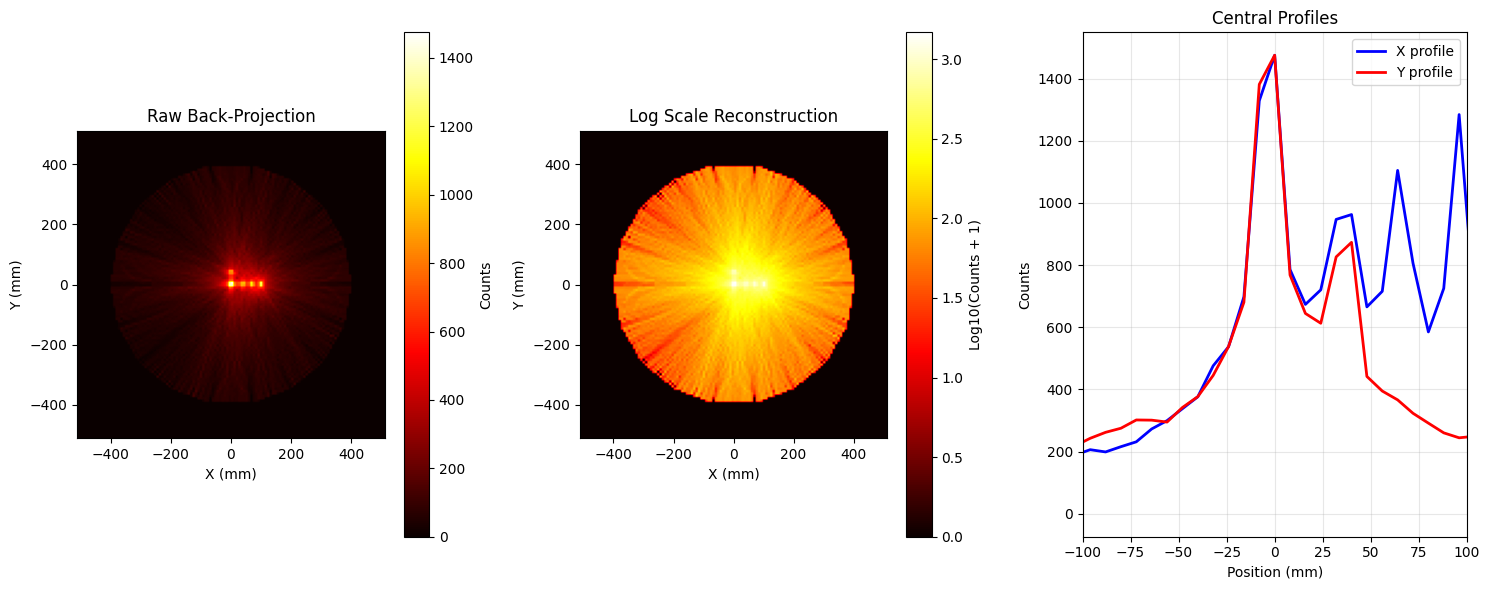

In [12]:

print("🚀 Starting PET reconstruction...")

# Reconstruct image
reconstructed_image = reconstruct_pet_image(coincidences, image_size=128, pixel_size=8.0)

# Analyze results
analyzed_image = analyze_reconstruction(reconstructed_image, pixel_size=8.0)

# Plot results
plot_reconstruction(reconstructed_image, pixel_size=8.0)